# Plotting the likelihood function across boundaries.

In [37]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import h5py
import tqdm
import emcee

from isochrones.mist import MIST_Isochrone
from isochrones import StarModel
mist = MIST_Isochrone()

from stardate.lhf import gyro_model
import corner

import stardate as sd
# from stardate.lhf import lnprob

In [585]:
def convective_turnover_time(*args):
    """
    Estimate the convective overturn time using equation 11 in Wright et al.
    (2011): https://arxiv.org/abs/1109.4634
    log tau = 1.16 - 1.49log(M/M⊙) - 0.54log^2(M/M⊙)
    (I assume log is log10)
    params:
    ------
    EITHER:
    mass: (float)
        Mass in Solar units
    OR
    eep: (float)
        The Equivalent evolutionary point of a star. 355 for the Sun.
    age: (float)
        The age of a star in log_10(years).
    feh: (float)
        The metallicity of a star.
    """

    if len(args) > 1:
        # Convert eep, age and feh to mass (mass will be in Solar mass units)
        eep, age, feh = args
        M = mist.mass(eep, age, feh)
    else:
        M = args[0]

    log_tau = 1.16 - 1.49*np.log10(M) - .54*(np.log10(M))**2
    return 10**log_tau


def gyro_model_rossby(mass, ag, bv, Ro_cutoff=2.16):
    """
    For a given mass, what is the final period, ie what is the period for Ro = 2.16?
    """
    age_myr = (10**params[1])*1e-6
    a, b, c, n = [.4, .31, .45, .55]
    
    pmax = Ro_cutoff * convective_turnover_time(params[0], params[1], params[2])
#     print("pmax", pmax)
    age_thresh_myr = (pmax/(a*(bv-c)**b))**(1./n)
    print("age_thresh_myr", age_thresh_myr)
    log10_age_thresh = np.log10(age_thresh_myr*1e6)
#     print("log10_age_thresh", log10_age_thresh, "age", params[1])
    
    if params[1] < log10_age_thresh:
#         print("age < log10_age_thresh")
        log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)
#         print("P", 10**log_P)
        
    else:
        log_P = np.log10(pmax)
#         print("log10_age_thresh < age")
#         print("P", 10**log_P)
    return 10**log_P


def lnprob(lnparams, *args):
    """
    The ln-probability function.
    lnparams are [eep, log10(age [yrs]), [Fe/H], ln(distance [kpc]), A_v]
    If EEP is greater than 425, the star has started evolving up the
    subgiant branch, so it should have a precise isochronal age and an
    unreliable gyro age -- shut gyrochronology off!
    If the Rossby number is greater than 2.16, shut gyrochronology off.
    """
    # Transform mass and distance back to linear.
    params = lnparams*1
    params[3] = np.exp(lnparams[3])

    mod, period, period_err, pmax, rossby_age, iso_only = args

    mag_pars = (params[0], params[1], params[2], params[3], params[4])
    B = mist.mag["B"](*mag_pars)
    V = mist.mag["V"](*mag_pars)
    bv = B-V

    # If the prior is -inf, don't even try to calculate the isochronal
    # likelihood.
    lnpr = mod.lnprior(params)
    if not np.isfinite(lnpr):
        return lnpr, lnpr

    if iso_only:
        return mod.lnlike(params) + lnpr, lnpr

    # Check that the star is cool, but not too cool, that the period is a
    # positive, finite number, it's on the MS, and its Rossby number is low.
    # tau = convective_overturn_time(params[0], params[1], params[2])
    # if bv > .45 and period and np.isfinite(period) and 0. < period \
    #         and params[0] < 454 and period/tau < 2.16:
    
    if not period or not np.isfinite(period) or period <= 0.:
        gyro_lnlike = -.5*((5/20.)**2)
    
    # If cool and MS:
    elif bv > .45 and params[0] < 454:
        gyro_lnlike = -.5*((period - gyro_model(params[1], bv))
                            /period_err)**2 - np.log(period_err)
        

#     print(gyro_lnlike)
    # If hot and MS:
#     elif bv < .45 and period and np.isfinite(period) and 0. < period \
#             and params[0] < 454:
#         gyro_lnlike = -.5*((period - .5/.55)**2)
    # The prior on rotation periods.
        
#     elif bv < .45 and period and np.isfinite(period) and 0. < period \
#             and params[0] < 454:
#         gyro_lnlike = -.5*((period - .5)
#                             /(period_err*100))**2 - np.log(100*period_err)

    else: 
#         gyro_lnlike = -.5*((period - .5/.55)**2)
        gyro_lnlike = -.5*((period - 5/20.)**2) - np.log(period_err)
#         gyro_lnlike = -.5*((period - .5)/(period_err*100))**2 - np.log(100*period_err)

#     print(period, np.isfinite(period), gyro_lnlike)

#     print("iso_like", mod.lnlike(params), "gyro_like", gyro_lnlike, "lnpr", lnpr)
    return mod.lnlike(params) + gyro_lnlike + lnpr, mod.lnlike(params), gyro_lnlike, lnpr

In [506]:
def set_params(eep, age, feh):
    """
    Set EEP, age and feh and determine other parameters from those.
    """
    logg = mist.logg(eep, age, feh)
    teff = mist.Teff(eep, age, feh)
    iso_params = pd.DataFrame(dict({"teff": (teff, 10),
                                    "logg": (logg, .05),
                                    "feh": (0., .001),
                                    "parallax": (1., .01)}))  # mas
    mag_pars = [eep, age, feh, 1000., 0.]
    bv = mist.mag["B"](*mag_pars) - mist.mag["V"](*mag_pars)
    prot = gyro_model(age, bv)
    return iso_params, mist.mass(eep, age, feh), bv, prot

In [507]:
def calc_lnprob(eep, age, feh):
    # Calculate the lnprob
    lnparams = [eep, age, feh, np.log(1000.), 0.]
    return lnprob(lnparams, *args)

In [508]:
true_eep, true_age, true_feh = 405, np.log10(2.295*1e9), 0.
iso_params, mass, bv, prot = set_params(true_eep, true_age, true_feh)

# Setup star model
mod = StarModel(mist, **iso_params)  # Set up the StarModel isochrones object.
args = [mod, prot, 1., False]  # the lnprob arguments]

print("mass = ", mass)
print("B-V = ", bv)
print("prot = ", prot)
print(prob)

mass =  1.5121592028713062
B-V =  0.42914088866386635
prot =  nan
(-25.227598646350742, -2.465190328815662e-28, -0.0, -25.227598646350742)


/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:43: RuntimeWarning: invalid value encountered in log10
  log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)


In [509]:
N = 100
eeps = np.linspace(395, 410, N)
probs, iso_probs, gyro_probs, priors, bvs = [np.zeros(N) for i in range(5)]

for i in tqdm.trange(N):
    _, _mass, _bv, _prot = set_params(eeps[i], true_age, true_feh)
    bvs[i] = _bv
    p = calc_lnprob(eeps[i], true_age, true_feh)
    probs[i], iso_probs[i], gyro_probs[i], priors[i] = p[0], p[1], p[2], p[3]

  0%|          | 0/100 [00:00<?, ?it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:43: RuntimeWarning: invalid value encountered in log10
  log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)
100%|██████████| 100/100 [00:00<00:00, 738.94it/s]


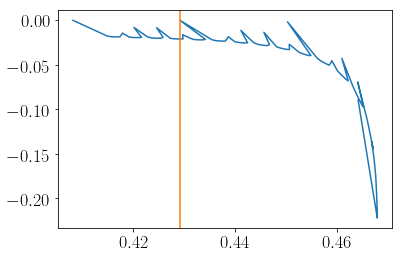

In [510]:
plt.plot(bvs, iso_probs)
plt.axvline(bv, color="tab:orange")

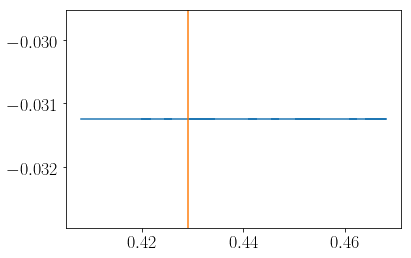

In [512]:
plt.plot(bvs, gyro_probs)
plt.axvline(bv, color="tab:orange")

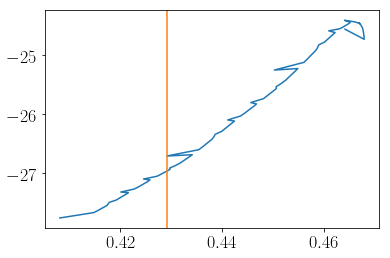

In [513]:
plt.plot(bvs, probs)
plt.axvline(bv, color="tab:orange")

In [515]:
true_eep, true_age, true_feh = 450, np.log10(3*1e9), 0.
iso_params, mass, bv, prot = set_params(true_eep, true_age, true_feh)

# Setup star model
mod = StarModel(mist, **iso_params)  # Set up the StarModel isochrones object.
args = [mod, prot, 1., False]  # the lnprob arguments]

print("mass = ", mass)
print("B-V = ", bv)
print("prot = ", prot)
print(prob)

mass =  1.3894404771515674
B-V =  0.46942811626649394
prot =  9.635853677196272
(-25.227598646350742, -2.465190328815662e-28, -0.0, -25.227598646350742)


In [516]:
N = 100
eeps = np.linspace(440, 460, N)
probs, iso_probs, gyro_probs, priors, bvs = [np.zeros(N) for i in range(5)]

for i in tqdm.trange(N):
    _, _mass, _bv, _prot = set_params(eeps[i], true_age, true_feh)
    bvs[i] = _bv
    p = calc_lnprob(eeps[i], true_age, true_feh)
    probs[i], iso_probs[i], gyro_probs[i], priors[i] = p[0], p[1], p[2], p[3]

  0%|          | 0/100 [00:00<?, ?it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:43: RuntimeWarning: invalid value encountered in log10
  log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)
100%|██████████| 100/100 [00:00<00:00, 591.60it/s]


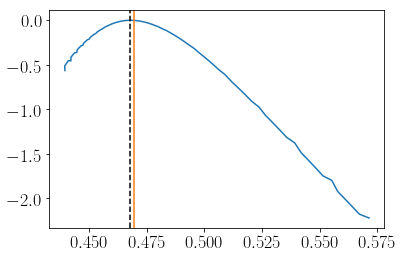

In [517]:
plt.plot(bvs, iso_probs)
plt.axvline(bv, color="tab:orange")
plt.axvline(bvs[iso_probs == max(iso_probs)], color="k", ls="--")

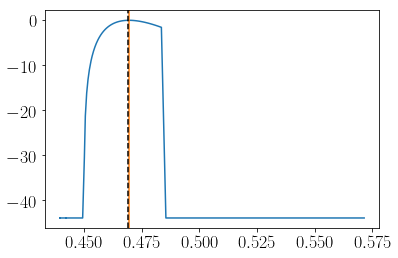

In [518]:
plt.plot(bvs, gyro_probs)
plt.axvline(bv, color="tab:orange")
plt.axvline(bvs[gyro_probs == max(gyro_probs[gyro_probs<0])], color="k", ls="--")
# print(gyro_probs)

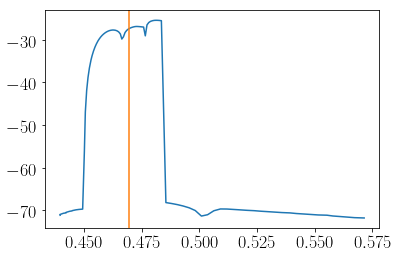

In [519]:
plt.plot(bvs, probs)
plt.axvline(bv, color="tab:orange")

Now look at giants.

In [520]:
true_eep, true_age, true_feh = 450, np.log10(4*1e9), 0.
iso_params, mass, bv, prot = set_params(true_eep, true_age, true_feh)

# Setup star model
mod = StarModel(mist, **iso_params)  # Set up the StarModel isochrones object.
args = [mod, prot, 1., False]  # the lnprob arguments]

print("mass = ", mass)
print("B-V = ", bv)
print("prot = ", prot)
print(prob)

mass =  1.2742894399687188
B-V =  0.5174999221524725
prot =  16.606457595890287
(-25.227598646350742, -2.465190328815662e-28, -0.0, -25.227598646350742)


In [521]:
N = 100
eeps = np.linspace(440, 460, N)
probs, iso_probs, gyro_probs, priors, bvs = [np.zeros(N) for i in range(5)]

for i in tqdm.trange(N):
    _, _mass, _bv, _prot = set_params(eeps[i], true_age, true_feh)
    bvs[i] = _bv
    p = calc_lnprob(eeps[i], true_age, true_feh)
    probs[i], iso_probs[i], gyro_probs[i], priors[i] = p[0], p[1], p[2], p[3]

100%|██████████| 100/100 [00:00<00:00, 618.17it/s]


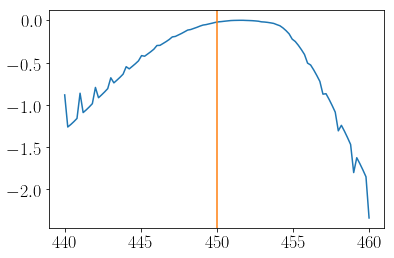

In [522]:
plt.plot(eeps, iso_probs)
plt.axvline(true_eep, color="tab:orange")

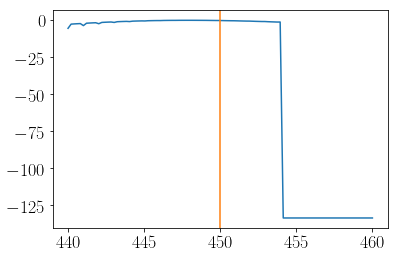

In [523]:
plt.plot(eeps, gyro_probs)
plt.axvline(true_eep, color="tab:orange")

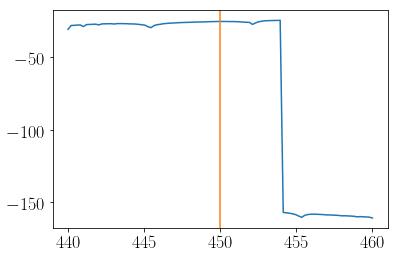

In [524]:
plt.plot(eeps, probs)
plt.axvline(true_eep, color="tab:orange")

In [525]:
true_eep, true_age, true_feh = 458, np.log10(4*1e9), 0.
iso_params, mass, bv, prot = set_params(true_eep, true_age, true_feh)

# Setup star model
mod = StarModel(mist, **iso_params)  # Set up the StarModel isochrones object.
args = [mod, prot, 1., False]  # the lnprob arguments]

print("mass = ", mass)
print("B-V = ", bv)
print("prot = ", prot)
print(prob)

mass =  1.2882046297409566
B-V =  0.5892736204273774
prot =  20.78702482864032
(-25.227598646350742, -2.465190328815662e-28, -0.0, -25.227598646350742)


In [526]:
N = 100
eeps = np.linspace(440, 460, N)
probs, iso_probs, gyro_probs, priors, bvs = [np.zeros(N) for i in range(5)]

for i in tqdm.trange(N):
    _, _mass, _bv, _prot = set_params(eeps[i], true_age, true_feh)
    bvs[i] = _bv
    p = calc_lnprob(eeps[i], true_age, true_feh)
    probs[i], iso_probs[i], gyro_probs[i], priors[i] = p[0], p[1], p[2], p[3]

100%|██████████| 100/100 [00:00<00:00, 643.33it/s]


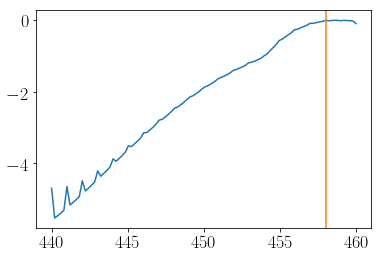

In [527]:
plt.plot(eeps, iso_probs)
plt.axvline(true_eep, color="tab:orange")

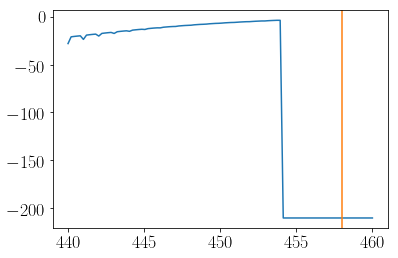

In [528]:
plt.plot(eeps, gyro_probs)
plt.axvline(true_eep, color="tab:orange")

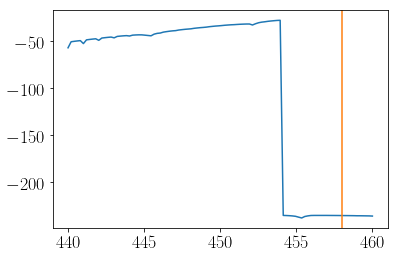

In [529]:
plt.plot(eeps, probs)
plt.axvline(true_eep, color="tab:orange")

In [530]:
N = 100000
ages = np.random.uniform(5., np.log10(13.8*1e9), N)
eeps = np.random.uniform(198, 490, N)
fehs = np.random.randn(N)*.2
distances = np.random.uniform(10., 1000., N)
avs = np.random.uniform(0., .2, N)

Find all the places where this combination produces B-V = .45

In [428]:
bv_map, teffs, loggs, prots = [np.zeros(N) for i in range(4)]
for i in range(N):
    mag_pars = [eeps[i], ages[i], fehs[i], distances[i], avs[i]]
    bv_map[i] = mist.mag["B"](*mag_pars) - mist.mag["V"](*mag_pars)
    prots[i] = gyro_model(ages[i], bv_map[i])
    teffs[i] = mist.Teff(eeps[i], ages[i], fehs[i])
    loggs[i] = mist.logg(eeps[i], ages[i], fehs[i])

/Users/ruthangus/anaconda/lib/python3.5/site-packages/stardate_code-0.0.1-py3.5.egg/stardate/lhf.py:43: RuntimeWarning: invalid value encountered in log10
  log_P = n*np.log10(age_myr) + np.log10(a) + b*np.log10(bv-c)


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less


(5.5, 2.5)

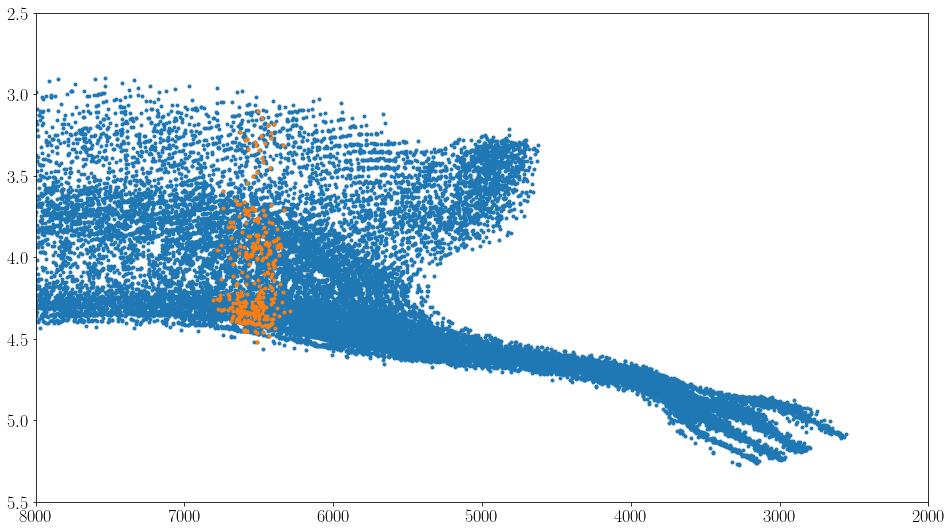

In [429]:
plt.figure(figsize=(16, 9))
# plt.scatter(teffs, loggs, c=bv_map)
# plt.colorbar()
plt.plot(teffs, loggs, ".")
bv_mask = (.45 < bv_map) * (bv_map < .46)
plt.plot(teffs[bv_mask], loggs[bv_mask], ".", color="tab:orange")
plt.xlim(8000, 2000)
plt.ylim(5.5, 2.5)

I could calculate gyro_lnprob for stars with a range of parameters and rotation periods at the border. And find the minimum lnprob. I would compute a lnprob for the orange stars over a range of rotation periods. Then I could look up the nearest star in the catalog and assign a lnprob based 

age_thresh_myr 12.040707829776789
age_thresh_myr 12.865614784140195
age_thresh_myr 13.759169384537286
age_thresh_myr 14.716319363169758
age_thresh_myr 15.735111981943438
age_thresh_myr 16.83971288101608
age_thresh_myr 18.038361137618292
age_thresh_myr 19.340857468695628
age_thresh_myr 20.7580193102819
age_thresh_myr 22.301877519774944
age_thresh_myr 23.98594058517184
age_thresh_myr 25.681634032217797
age_thresh_myr 27.41836029410246
age_thresh_myr 29.29852408444925
age_thresh_myr 31.21990082377565
age_thresh_myr 33.2946040545804
age_thresh_myr 35.537907687931714
age_thresh_myr 37.96617605041982
age_thresh_myr 40.59763552761308
age_thresh_myr 43.45261927731662
age_thresh_myr 46.553848637406986
age_thresh_myr 49.85884163712676
age_thresh_myr 53.141870114841225
age_thresh_myr 56.690228459759766
age_thresh_myr 60.27009747409905
age_thresh_myr 63.934569894245634
age_thresh_myr 67.87264173900277
age_thresh_myr 72.34290404534431
age_thresh_myr 77.17814127743749
age_thresh_myr 82.2082476547887

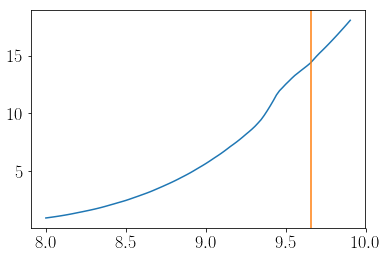

In [586]:
ages = np.linspace(8, np.log10(8*1e9), 100)
mass = mist.mass(355, np.log10(4.56*1e9), 0.)
periods = []
for age in ages:
    periods.append(gyro_model_rossby(mass, age, .65, 1.))
plt.plot(ages, periods)
plt.axvline(np.log10(4.56*1e9), color="tab:orange")

In [582]:
pmax, bv = 25, .65
a, b, c, n = [.4, .31, .45, .55]
(pmax/(a*(bv-c)**b))**(1./n)

4562.483498355086

In [583]:
pmax = 2.16 * convective_turnover_time(mass)